# Finding rought $T_g$

Find some good simulation statepoints for the MLJ potential

Current good statepoints

| $\Delta$    | $\rho$      | $P$       |
| ----------- | ----------- | --------- |
| 0.0         | 1.2         |           |
| 0.1         | 1.15        |           |
| 0.2         | 1.1         |           |
| 0.3         | 1.05        |           |
| 0.4         | 1.0         |           |
| 0.5         | 0.95        |           |
| 0.6         | 0.9         |           |

## Imports

In [89]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import glob

from numba import njit, vectorize, float32

from typing import Callable, Optional, Union

import hoomd
import gsd.hoomd

import sys
import time
import pickle
import gc

import signac

In [90]:
from monk import nb, prep, pair, render
import freud

When running simulations, we can't be sure the system is equilibrated until we observe consistent behaviour in the alpha relaxation beavior. Additionally, once the alpha relaxation has settled in on a steady value, we should wait at least a decade in the alpha relaxation timescale before collecting data.

In [95]:


class VerifyEquilibrium(hoomd.custom.Action):
    """Computes dynamics to verify equilibration."""

    def __init__(self, k: float = None):
        self.last_pos = None
        self.last_image = None
        self.last_tstep = None
        self.k = 7.14
    
    def act(self, timestep):
        snap = self._state.get_snapshot()
        if self.last_pos is None:
            self.last_pos = snap.particles.position
            self.last_image = snap.particles.image
            self.first_tstep = timestep
            self.last_tstep = timestep
            self.last_msd = 0.0
            self.alpha_time = 0.0
        else:
            dt = self._state._simulation.operations.integrator.dt
            pos = snap.particles.position
            image = snap.particles.image
            sim_box = self._state.box
            if sim_box.is2D:
                dim = 2
            else:
                dim = 3
            box = freud.box.Box.from_box(sim_box)
            unwrapped_pos = box.unwrap(pos, image - self.last_image)
            msd = np.mean(np.sum(np.square(unwrapped_pos - self.last_pos), axis=-1))

            D = (msd - self.last_msd) / (timestep - self.last_tstep) / dt / (2 * dim)
            self.last_tstep = timestep
            self.last_msd = msd

            x = self.k * np.linalg.norm(pos - self.last_pos, axis=-1)
            sisf = np.mean(np.sin(x)/x)

            # print(f"{D} {sisf}")

            self.alpha_time += (timestep - self.first_tstep) * dt
            if sisf < np.exp(-1.0):
                print(f"    D = {D}")
                print(f"    alpha = {self.alpha_time}")
                self.alpha_time = 0.0
                self.first_tstep = timestep
                self.last_pos = snap.particles.position
                self.last_image = snap.particles.image
            


In [92]:
N = 2**15

In [93]:
N

32768

In [96]:
sim = prep.quick_sim(N, 1.2, hoomd.device.GPU(), ratios=[80, 20], diams=[1.0, 0.88])

render.render_sphere_frame(sim.state.get_snapshot())

In [97]:
temp = 1.0
end_temp = 0.01
speed = 1e-2
steps = int(1_000*(temp-end_temp)/speed)
steps = 400_000
p = 1.0
delta = 0.0

eq_steps = 10_000

integrator = hoomd.md.Integrator(dt=0.001)
tree = hoomd.md.nlist.Tree(0.3)
mlj = pair.KA_ModLJ(tree, delta)
# variant = hoomd.variant.Ramp(temp, end_temp, sim.timestep + eq_steps, steps)
variant = 1.5
# nvt = hoomd.md.methods.NPT(hoomd.filter.All(), variant, 1.0, p, 1.0, "xyz", gamma=1.0)
nvt = hoomd.md.methods.NVT(hoomd.filter.All(), variant, 0.1)
integrator.forces = [mlj]
integrator.methods = [nvt]

sim.operations.integrator = integrator

sim.always_compute_pressure = True

sim.state.thermalize_particle_momenta(hoomd.filter.All(), 2.0)

sim.run(0)
# nvt.thermalize_thermostat_dof()

log = hoomd.logging.Logger(categories=["scalar"])
analyzer = hoomd.md.compute.ThermodynamicQuantities(filter=hoomd.filter.All())
# sim.operations.computes.append(analyzer)
# log.add(analyzer)

# file = open(f'_log_quench-test_rate-{speed}_p-{p}_d-{delta}.log', mode='w', newline='\n')
# table = hoomd.write.Table(hoomd.trigger.Periodic(1_000), output=file, logger=log)

writer = hoomd.write.GSD(hoomd.trigger.Periodic(10_000), f"test-params.gsd", mode="wb")
sim.operations.writers.clear()
sim.operations.writers.append(writer)
# sim.operations.writers.append(table)



In [98]:
sim.run(100_000)

In [99]:
custom_action = hoomd.update.CustomUpdater(hoomd.trigger.Periodic(1_000), VerifyEquilibrium())
sim.operations.updaters.clear()
sim.operations.updaters.append(custom_action)

# nvt.kT = 0.5

In [100]:
sim.run(100_000)

    D = 0.03693170131427345
    alpha = 1.0000000474974513
    D = -0.0001289067206742087
    alpha = 1.0000000474974513
    D = 0.00037620050019949823
    alpha = 1.0000000474974513
    D = 3.4290788086079406e-05
    alpha = 1.0000000474974513
    D = 0.00036006600693566665
    alpha = 1.0000000474974513
    D = -4.4521099227523845e-05
    alpha = 1.0000000474974513
    D = -0.0003226205594665059
    alpha = 1.0000000474974513
    D = 0.00018391333522184463
    alpha = 1.0000000474974513
    D = 0.0004803134462855263
    alpha = 1.0000000474974513
    D = -0.0004878504839011253
    alpha = 1.0000000474974513
    D = 0.0006827111488168163
    alpha = 1.0000000474974513
    D = -0.0006323306376672407
    alpha = 1.0000000474974513
    D = -1.656885120288393e-06
    alpha = 1.0000000474974513
    D = -2.7546948413140225e-05
    alpha = 1.0000000474974513
    D = -0.0003431217590720975
    alpha = 1.0000000474974513
    D = 0.000838490204967558
    alpha = 1.0000000474974513
    D = -0.00

KeyboardInterrupt: 

render.render_sphere_frame(sim.state.get_snapshot())

In [162]:
gc.collect()

682

In [ ]:
quench_params = {
    0.0: {
        1.5
    }
}

## Potential form

What does this look like again for different $\Delta$ values?

In [100]:
def mlj(r, delta):
    sigma = 1 - delta*2**(-1/6)
    term = sigma/(r - delta)
    return 4 * (term**12 - term**6)

/tmp/ipykernel_9504/3357127588.py:3: RuntimeWarning: divide by zero encountered in true_divide
  term = sigma/(r - delta)
/tmp/ipykernel_9504/3357127588.py:4: RuntimeWarning: invalid value encountered in subtract
  return 4 * (term**12 - term**6)


Text(0.5, 0, '$r$')

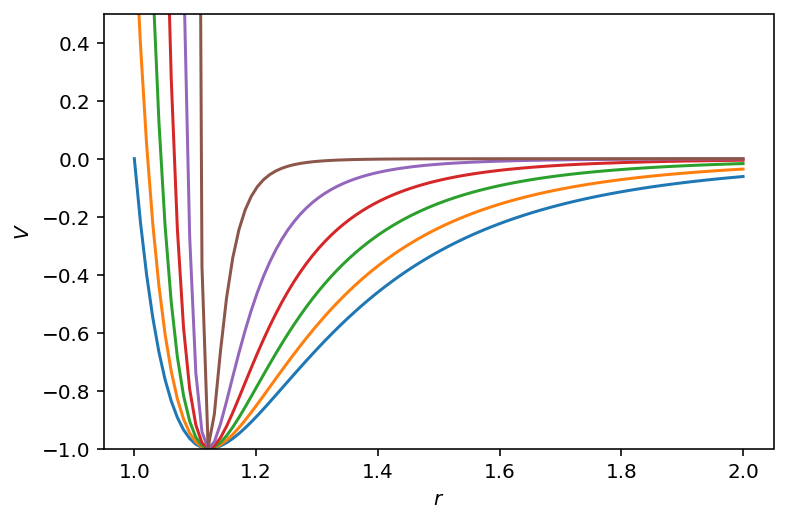

In [105]:
x = np.linspace(1.0, 2.0, 100)

for d in np.linspace(0.0, 1.0, 6):
    plt.plot(x, mlj(x, d))

plt.ylim(-1, 0.5)
plt.ylabel(r"$V$")
plt.xlabel(r"$r$")

## Inspect logs

In [150]:
logs = glob.glob("_log_*p-1.0*.log")

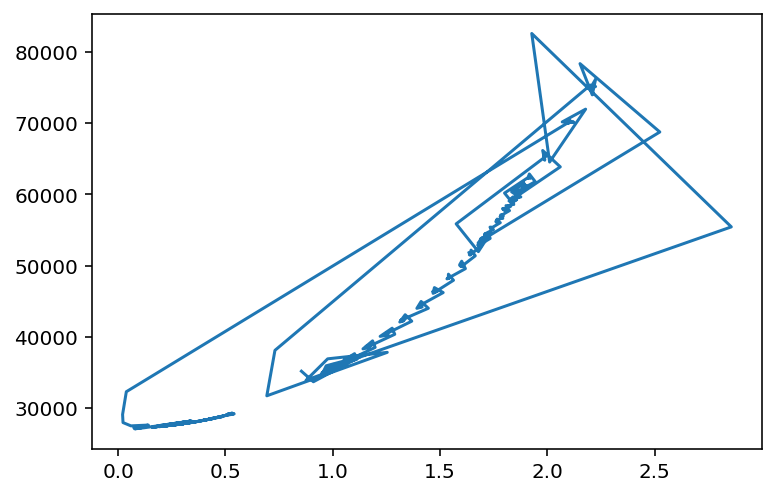

In [152]:
label = 2

for log_file in logs:
    df = pd.read_csv(log_file, sep='\s+', header=0)
    l, = plt.plot(df["md.compute.ThermodynamicQuantities.kinetic_temperature"], df["md.compute.ThermodynamicQuantities.volume"])
# plt.yscale('log')
# plt.xscale('log')

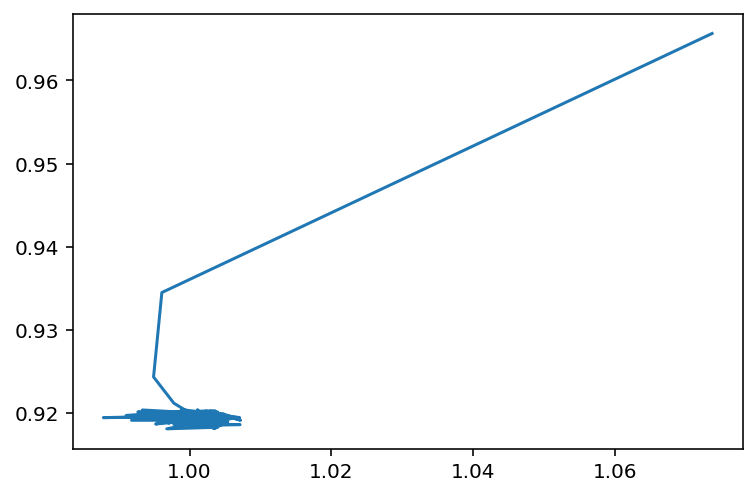

In [85]:
label = 2

for log_file in logs:
    df = pd.read_csv(log_file, sep='\s+', header=0)
    l, = plt.plot(df["md.compute.ThermodynamicQuantities.kinetic_temperature"], N/df["md.compute.ThermodynamicQuantities.volume"])

In [86]:
logs

['_log_quench-test_rate-0.01_p-1.0_d-0.0.log']

_log_quench-test_rate-0.1_p-50.0_speed-0.1.log 1.5950672669701398
_log_quench-test_rate-0.01_p-50.0_speed-0.01.log 1.5769634525066683


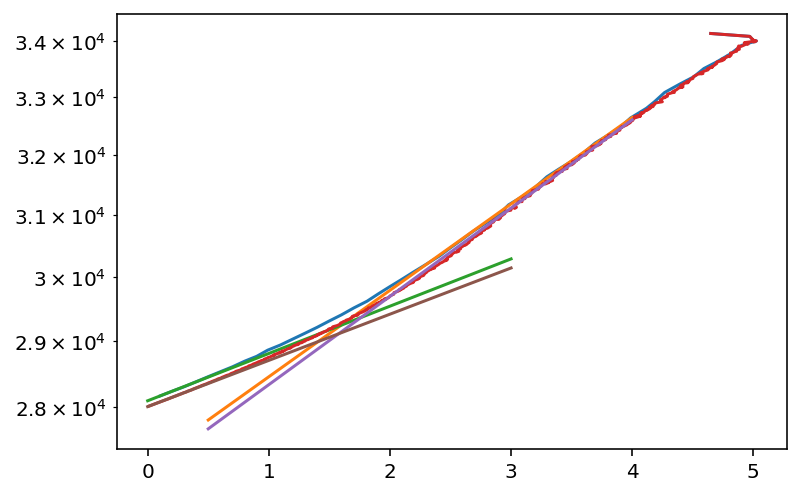

In [105]:
for log_file in logs:
    df = pd.read_csv(log_file, sep='\s+', header=0)
    x = df["md.compute.ThermodynamicQuantities.kinetic_temperature"]
    y = df["md.compute.ThermodynamicQuantities.volume"]
    plt.plot(x, y)

    cond = np.logical_and(x < 4.0, x > 3.0)
    fit = np.polyfit(x[cond], np.log(y[cond]), 1)
    xd = np.linspace(.5, 4.0, 100)
    plt.plot(xd, np.exp(xd*fit[0] + fit[1]))


    cond = x < 0.3
    fit2 = np.polyfit(x[cond], np.log(y[cond]), 1)
    xd = np.linspace(0.0, 3.0, 100)
    plt.plot(xd, np.exp(xd*fit2[0] + fit2[1]))

    print(log_file, (fit[1] - fit2[1])/(fit2[0] - fit[0]))

plt.yscale('log')